In [1]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
from models.aa_common.performance_metrics import *

In [2]:
task = "pmd_analysis"
# ("dbnsfp", "sift"), ("dbnsfp", "polyphen2_HVAR"), ("dbnsfp", "cadd"), ("dbnsfp", "mvp"), ("dbnsfp", "metarnn"), ("dbnsfp", "revel"),
model_root_and_name_tuple_list = [("tape_rao", "unirep"), ("tape_rao", "protbert"), ("sequnet_dunham", "sequnet"), 
                                  ("esm_rives", "esm1b_t33_650M_UR50S"), ("esm_rives", "esm1v_t33_650M_UR90S"), ("esm_rives", "esm2_t33_650M_UR50D"),
                                  ("bioembeddings_dallago", "plus_rnn"), 
                                  ("bioembeddings_dallago", "prottrans_bert_bfd"), ("bioembeddings_dallago", "prottrans_albert_bfd"),
                                  ("bioembeddings_dallago", "prottrans_xlnet_uniref100"), 
                                  ("bioembeddings_dallago", "prottrans_t5_bfd"), ("bioembeddings_dallago", "prottrans_t5_uniref50"), ("bioembeddings_dallago", "prottrans_t5_xl_u50")]

# by default, we consider larger means positive class (here Effect), but the following models have specific opposite meaning
models_smaller_means_damaging = ["sequnet", "sift"]

metrics = ["AUC-ROC", "AUC-PR", "F1-max", "Th-max", "Precision", "Recall", "Accuracy", "Balanced-accuracy", "MCC"]

In [3]:
result_df = pd.read_csv(home_dir+f"models/aa_common/merged_predictions/{task}.csv", sep="\t")
# result_df = result_df[(result_df["functional_effect"]=="Effect") | (result_df["functional_effect"]=="No effect")]
print(result_df.shape)
print(result_df.columns)

result_df.loc[(result_df["functional_effect"]=="Effect") | (result_df["functional_effect"]=="Knock-out"), "class_numeric"] = 1
result_df.loc[result_df["functional_effect"]=="No effect", "class_numeric"] = 0

result_df["class_numeric"].value_counts()

(51047, 28)
Index(['mut_id', 'pmd_id', 'protein', 'mut_PMD', 'mut_real', 'function',
       'taxid', 'function_e', 'function_e2', 'functional_effect', 'seq',
       'protein_id', 'wt', 'mut', 'prot_pos', 'unirep_pred', 'protbert_pred',
       'sequnet_pred', 'esm1b_t33_650M_UR50S_pred',
       'esm1v_t33_650M_UR90S_pred', 'esm2_t33_650M_UR50D_pred',
       'plus_rnn_pred', 'prottrans_bert_bfd_pred', 'prottrans_albert_bfd_pred',
       'prottrans_xlnet_uniref100_pred', 'prottrans_t5_bfd_pred',
       'prottrans_t5_uniref50_pred', 'prottrans_t5_xl_u50_pred'],
      dtype='object')


1.0    37750
0.0    13297
Name: class_numeric, dtype: int64

### Computing all methods performance metrics

In [6]:
output_file = home_dir+f"models/aa_common/performance_analysis/{task}.csv"

out = open(output_file, 'w')
out.write("Models\\Metrics")
for metric in metrics:
    out.write(f"\t{metric}")
out.write("\n")

for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    print(model_name)
    model_pred_col = model_name + "_pred"
    result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]
    
    non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values
    
    if model_name in models_smaller_means_damaging:
        non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

    auc_roc_score, larger_means_positive_class = get_auc_roc_score(non_nan_result_df)
    if not larger_means_positive_class:
        non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
    
    auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
    f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
    precision = get_precision_score(non_nan_result_df, th_max)
    recall = get_recall_score(non_nan_result_df, th_max)
    accuracy = get_accuracy_score(non_nan_result_df, th_max)
    balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
    mcc = get_matthews_corrcoef(non_nan_result_df, th_max)
    
    permformance_scores = [auc_roc_score, auc_pr_score, f1_max, th_max, precision, recall, accuracy, balanced_accuracy, mcc]
    
    out.write(f"{model_name}")
    for score in permformance_scores:
        out.write(f"\t{score:.3f}")
    out.write("\n")
        
    
    # if i==5: break

out.close()

unirep
	AUC-ROC: 0.513
	AUC-PR: 0.745
	Best F1-Score: 0.850 at threshold: 0.000
	Precision score: 0.740 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.740 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000
protbert
	AUC-ROC: 0.478
	AUC-PR: 0.768
	Best F1-Score: 0.850 at threshold: -1.000
	Precision score: 0.740 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.740 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
sequnet


/tmp/ipykernel_1501633/3004548859.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
/tmp/ipykernel_1501633/3004548859.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	AUC-ROC: 0.402
	AUC-PR: 0.798
	Best F1-Score: 0.850 at threshold: 0.000
	Precision score: 0.740 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.740 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000
esm1b_t33_650M_UR50S
	AUC-ROC: 0.332
	AUC-PR: 0.843
	Best F1-Score: 0.850 at threshold: -1.000
	Precision score: 0.740 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.740 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
esm1v_t33_650M_UR90S
	AUC-ROC: 0.339
	AUC-PR: 0.843
	Best F1-Score: 0.850 at threshold: -1.000
	Precision score: 0.740 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.740 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
esm2_t33_650M_UR50D
	AUC-ROC: 0.329
	AUC-PR: 0.849
	Best F1-Score: 0.850 

### Computing random classifiers average performance metrics of 10 runs

In [7]:
import random

model_name = "random_classifier"
auc_roc_score_list, auc_pr_score_list, f1_max_list, th_max_list, precision_list, recall_list, accuracy_list, balanced_accuracy_list, mcc_list = [], [], [], [], [], [], [], [], []

for i in range(10):
    result_df["pred"] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
    non_nan_result_df = result_df.copy(deep=True)
        
    auc_roc_score = get_auc_roc_score(non_nan_result_df)
    auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
    f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
    precision = get_precision_score(non_nan_result_df, th_max)
    recall = get_recall_score(non_nan_result_df, th_max)
    accuracy = get_accuracy_score(non_nan_result_df, th_max)
    balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
    mcc = get_matthews_corrcoef(non_nan_result_df, th_max)

    auc_roc_score_list.append(auc_roc_score)
    auc_pr_score_list.append(auc_pr_score)
    f1_max_list.append(f1_max)
    th_max_list.append(th_max)
    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    balanced_accuracy_list.append(balanced_accuracy)
    mcc_list.append(mcc)
    

permformance_scores = [np.mean(auc_roc_score_list), np.mean(auc_pr_score_list), np.mean(f1_max_list), 
                       np.mean(th_max_list), np.mean(precision_list), np.mean(recall_list), 
                       np.mean(accuracy_list), np.mean(balanced_accuracy_list), np.mean(mcc_list)]
    
output_file = home_dir+f"models/aa_common/performance_analysis/{task}.csv"
out = open(output_file, 'a')

out.write(f"{model_name}")
for score in permformance_scores:
    out.write(f"\t{score:.3f}")
out.write("\n")
out.close()

	AUC-ROC: 0.496
	AUC-PR: 0.737
	Best F1-Score: 0.850 at threshold: 0.000
	Precision score: 0.740 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.740 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000
	AUC-ROC: 0.503
	AUC-PR: 0.741
	Best F1-Score: 0.850 at threshold: 0.000
	Precision score: 0.740 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.740 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.007 at threshold: 0.000
	AUC-ROC: 0.499
	AUC-PR: 0.740
	Best F1-Score: 0.850 at threshold: 0.000
	Precision score: 0.740 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.740 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000
	AUC-ROC: 0.497
	AUC-PR: 0.737
	Best F1-Score: 0.850 at threshold: 0.000
	Precision score: 0.740 at threshold: 0.000
	Recall sc

### Plotting the prediction score distributions

unirep
protbert
sequnet


/tmp/ipykernel_2459573/1654407499.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


esm1b_t33_650M_UR50S
esm1v_t33_650M_UR90S
esm2_t33_650M_UR50D
plus_rnn
prottrans_bert_bfd
prottrans_albert_bfd
prottrans_xlnet_uniref100
prottrans_t5_bfd
prottrans_t5_uniref50
prottrans_t5_xl_u50


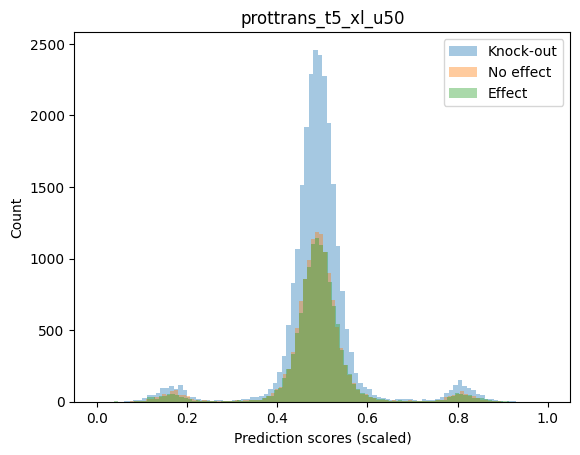

In [10]:
import matplotlib.pyplot as plt

def plot_distribution(result_df):
    plt.cla()
    effect = result_df[result_df["functional_effect"]=="Effect"]
    knock_out = result_df[result_df["functional_effect"]=="Knock-out"]
    no_effect = result_df[result_df["functional_effect"]=="No effect"]

    bins = 100 # 20, 100, 500
    plt.hist(knock_out["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Knock-out")
    plt.hist(no_effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"No effect")
    plt.hist(effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Effect")
    

    plt.title(f"{model_name}")
    plt.legend()
    plt.xlabel("Prediction scores (scaled)")
    plt.ylabel("Count")
    # plt.show()
    plt.savefig(home_dir+f"models/aa_common/pred_scores_distribution_plots_pmd_analysis/{model_name}.png", dpi=300, format="png", bbox_inches='tight', pad_inches=0.0)

for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    print(model_name)
    # model_name = "esm2_t33_650M_UR50D"
    model_pred_col = model_name + "_pred"

    result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

    non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values

    if model_name in models_smaller_means_damaging:
        non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

    plot_distribution(non_nan_result_df)
    # break

	AUC-PR: 0.361
(25873,)
	Best F1-Score: 0.655 at threshold: 0.000
(25868,)
[0.48721607 0.4871963  0.48717652 ... 0.14285714 0.16666667 1.        ]
[1.00000000e+00 9.99920849e-01 9.99841697e-01 ... 7.91514960e-05
 7.91514960e-05 0.00000000e+00]


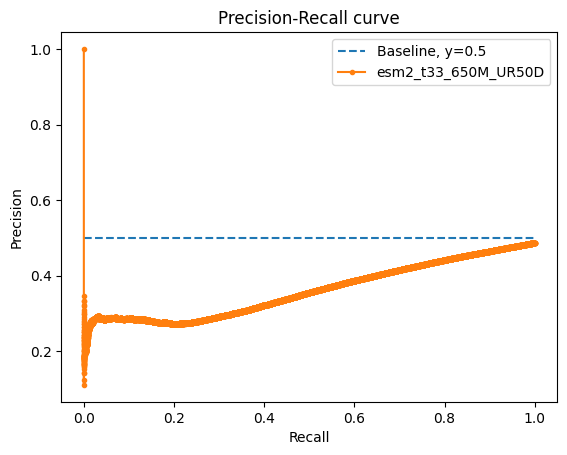

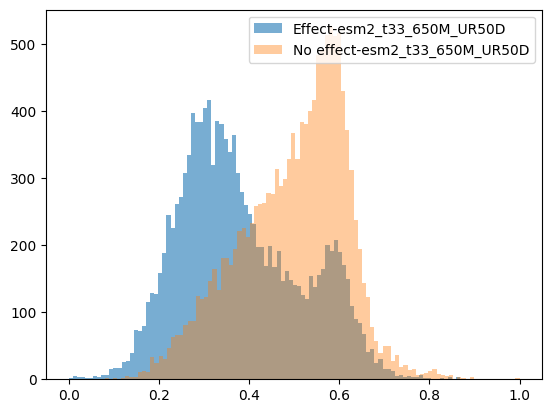

In [7]:

    

model_name = "esm2_t33_650M_UR50D"
model_pred_col = model_name + "_pred"

result_df.loc[result_df["functional_effect"]=="Effect", "class_numeric"] = 1
result_df.loc[result_df["functional_effect"]=="No effect", "class_numeric"] = 0

result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values

if model_name in models_smaller_means_damaging:
    non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
print(thresholds.shape)
f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
print(thresholds.shape)
print(precisions, recalls, sep="\n")

# f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th_(non_nan_result_df)

import matplotlib.pyplot as plt
plt.plot([0,1], [.5, .5], linestyle='--', label='Baseline, y=0.5')
plt.plot(recalls, precisions, marker='.', label=f'{model_name}')
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.title("Precision-Recall curve")
plt.show()


effect = result_df[result_df["functional_effect"]=="Effect"]
no_effect = result_df[result_df["functional_effect"]=="No effect"]

bins = 100 # 20, 100, 500
plt.hist(effect["pred"], bins=bins, density=False, log=False, alpha=.6, label=f"Effect-{model_name}")
plt.hist(no_effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"No effect-{model_name}")

plt.legend()
plt.show()